In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import nltk

nltk.download('punkt')



[nltk_data] Downloading package punkt to
[nltk_data]     /home/vnatireddi1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
# Print the class distribution for the training set
import pandas as pd
data = pd.read_csv('/home/vnatireddi1/projects/meld/Text_Analysis/train_sent_emo.csv', encoding='latin1')
print("Training set class distribution:")
print(data['Emotion'].value_counts())
print(data['Sentiment'].value_counts())



Training set class distribution:
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: Emotion, dtype: int64
neutral     4710
negative    2945
positive    2334
Name: Sentiment, dtype: int64


In [16]:
#!pip install imbalanced-learn

import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

# Load the train dataset
train_df = pd.read_csv('/home/vnatireddi1/projects/meld/Text_Analysis/train_sent_emo.csv', encoding='latin1')

# Print the class distribution for the original training set
print("Original training set class distribution:")
print(train_df['Sentiment'].value_counts())

# Split the training set into features and target label
X_train = train_df['Utterance'].values
y_train = train_df['Sentiment'].values

# Undersample the majority class (neutral) using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={'neutral': int(train_df['Sentiment'].value_counts().min())}, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train.reshape(-1, 1), y_train)

# Convert the undersampled data back to pandas dataframe
train_resampled_df = pd.DataFrame({'Utterance': X_train_resampled.squeeze(), 'Sentiment': y_train_resampled})

# Print the class distribution for the resampled training set
print("\nResampled training set class distribution:")
print(train_resampled_df['Sentiment'].value_counts())


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Original training set class distribution:
neutral     4710
negative    2945
positive    2334
Name: Sentiment, dtype: int64

Resampled training set class distribution:
negative    2945
neutral     2334
positive    2334
Name: Sentiment, dtype: int64


In [20]:
import re
import nltk
nltk.download('stopwords')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import re


def clean_text(text):
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = text.lower() # convert to lowercase
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

train_resampled_df['clean_text'] = train_resampled_df['Utterance'].apply(lambda x: clean_text(x))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vnatireddi1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
le = LabelEncoder()
train_resampled_df['Sentiment'] = le.fit_transform(train_resampled_df['Sentiment'])

In [23]:
train_resampled_df.head()

,Utterance,Sentiment,clean_text
0,No donÂt I beg of you!,0,donât beg
1,But then who? The waitress I went out with las...,0,waitress went last month
2,You know? Forget it!,0,know forget
3,"No-no-no-no, no! Who, who were you talking about?",0,nononono talking
4,"No, I-I-I-I don't, I actually don't know",0,iiii dont actually dont know


In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_resampled_df['clean_text'], train_resampled_df['Sentiment'], test_size=0.2, random_state=42)

In [25]:
# Apply count vectorization and tf-idf transformation to the training and testing data
cv = CountVectorizer()
X_train_counts = cv.fit_transform(X_train)
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)
X_test_counts = cv.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_counts)

In [27]:
import pandas as pd
import numpy as np
import transformers
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertForSequenceClassification


from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Train a logistic regression model on the preprocessed data
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

# Evaluate the logistic regression model on the testing data
lr_pred = lr.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, lr_pred)
report = classification_report(y_test, lr_pred, target_names=le.classes_)

print("Accuracy:", accuracy)
print("Classification report:\n", report)


Accuracy: 0.520682862770847
Classification report:
               precision    recall  f1-score   support

    negative       0.55      0.66      0.60       617
     neutral       0.46      0.39      0.42       454
    positive       0.53      0.46      0.49       452

    accuracy                           0.52      1523
   macro avg       0.51      0.50      0.50      1523
weighted avg       0.52      0.52      0.51      1523



/home/vnatireddi1/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [3]:
# Load the MELD dataset
with open('/home/vnatireddi1/projects/meld/Text_Analysis/train_sent_emo.csv', 'r') as f:
    lines = f.readlines()

X_train = []
y_train = []
for line in lines[1:]:
    cols = line.strip().split(',')
    text = cols[1].strip()
    label = cols[2].strip()
    X_train.append(text)
    y_train.append(label)

# with open('meld/dev_sent_emo.csv', 'r') as f:
#     lines = f.readlines()

# X_test = []
# y_test = []
# for line in lines[1:]:
#     cols = line.strip().split(',')
#     text = cols[1].strip()
#     label = cols[2].strip()
#     X_test.append(text)
#     y_test.append(label)

In [6]:

# Load the GloVe embeddings
glove = {}
with open('glove.6B.50d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove[word] = vector

# Vectorize the text using GloVe embeddings
X_train_vectors = []
for text in X_train:
    vectors = []
    for word in nltk.word_tokenize(text.lower()):
        if word in glove:
            vectors.append(glove[word])
    if not vectors:
        vectors.append([0] * 300)
    vector = np.mean(vectors, axis=0)
    X_train_vectors.append(vector)

X_test_vectors = []
for text in X_test:
    vectors = []
    for word in nltk.word_tokenize(text.lower()):
        if word in glove:
            vectors.append(glove[word])
    if not vectors:
        vectors.append([0] * 300)
    vector = np.mean(vectors, axis=0)
    X_test_vectors.append(vector)



UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 6030: invalid start byte

In [ ]:
# Train the classifier
clf = RandomForestClassifier()
clf.fit(X_train_vectors, y_train)

# Test the classifier
y_pred = clf.predict(X_test_vectors)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

## LSTM ON TEXT

In [65]:
import pandas as pd

# Load the MLED dataset
df = pd.read_csv('/home/vnatireddi1/projects/meld/Text_Analysis/train_sent_emo.csv', encoding='latin1')

# Preprocess the dataset
df = df[['Utterance', 'Sentiment']]  # Keep only the text and label columns
df['Utterance'] = df['Utterance'].apply(lambda x: x.lower())  # Convert text to lowercase


In [66]:
import re
import nltk
nltk.download('stopwords')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import re


def clean_text(text):
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = text.lower() # convert to lowercase
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

df['clean_text'] = df['Utterance'].apply(lambda x: clean_text(x))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vnatireddi1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Define the maximum number of words to keep
max_words = 10000

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Define the maximum sequence length
max_sequence_length = 100

# Pad the sequences to make them of equal length
data = pad_sequences(sequences, maxlen=max_sequence_length)
labels = df['Sentiment'].values


In [60]:

from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

# Define the model architecture
model = Sequential()
model.add(Embedding(max_words, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [61]:
# Split the data into training and testing sets
train_size = int(0.8 * len(data))
train_data = data[:train_size]

train_data = np.array(train_data).astype('float32')

train_labels = labels[:train_size]

test_data = data[train_size:]
test_data = np.array(test_data).astype('float32')

test_labels = labels[train_size:]

# Train the model
model.fit(train_data, train_labels, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5


ValueError: in user code:

    File "/usr/local/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.8/site-packages/keras/losses.py", line 1789, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.8/site-packages/keras/backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_data, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


In [74]:
import pandas as pd

# Load the MLED dataset
df = pd.read_csv('/home/vnatireddi1/projects/meld/Text_Analysis/train_sent_emo.csv', encoding='latin1')

# Preprocess the dataset
df = df[['Utterance', 'Sentiment']]  # Keep only the text and label columns
df['Utterance'] = df['Utterance'].apply(lambda x: x.lower())  # Convert text to lowercase

le = LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment'])

def clean_text(text):
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = text.lower() # convert to lowercase
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    return text

df['clean_text'] = df['Utterance'].apply(lambda x: clean_text(x))



from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Define the maximum number of words to keep
max_words = 10000

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Define the maximum sequence length
max_sequence_length = 100

# Pad the sequences to make them of equal length
data = pad_sequences(sequences, maxlen=max_sequence_length)
labels = df['Sentiment'].values




from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

# Define the model architecture
model = Sequential()
model.add(Embedding(max_words, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
train_data = data[:train_size]
train_labels = labels[:train_size]
test_data = data[train_size:]
test_labels = labels[train_size:]

# Convert the labels to one-hot encoded vectors/
train_labels = to_categorical(train_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)

# Train the model
model.fit(train_data, train_labels, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
200/200 [==============================] - 42s 185ms/step - loss: 1.0275 - accuracy: 0.4928 - val_loss: 1.0012 - val_accuracy: 0.5022
Epoch 2/5
200/200 [==============================] - 38s 189ms/step - loss: 0.8500 - accuracy: 0.6147 - val_loss: 1.0400 - val_accuracy: 0.4903
Epoch 3/5
200/200 [==============================] - 37s 182ms/step - loss: 0.6956 - accuracy: 0.6959 - val_loss: 1.1391 - val_accuracy: 0.4847
Epoch 4/5
200/200 [==============================] - 31s 155ms/step - loss: 0.5844 - accuracy: 0.7497 - val_loss: 1.2428 - val_accuracy: 0.4978
Epoch 5/5
200/200 [==============================] - 36s 179ms/step - loss: 0.5193 - accuracy: 0.7719 - val_loss: 1.3396 - val_accuracy: 0.4916


63/63 - 1s - loss: 1.3239 - accuracy: 0.5030 - 1s/epoch - 23ms/step
Test accuracy: 0.5030030012130737


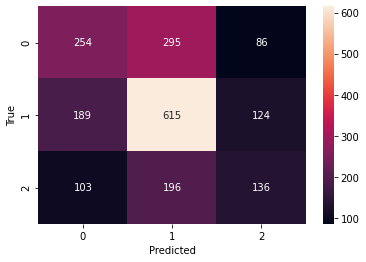

In [75]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

# Predict the test labels
y_pred = model.predict(test_data)

# Convert the predictions to class labels
y_pred = np.argmax(y_pred, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Print the accuracy
print('Test accuracy:', test_acc)

# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [70]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
